## Importing required libraries

In [54]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

Root = "C:/Things/Uni/year3/semester2/MI/projekt/training-data/archive"
os.chdir(Root)
np.random.seed(42)

## Assigning path for dataset

In [2]:
data_dir = "C:/Things/Uni/year3/semester2/MI/projekt/training-data/archive"
train_path = 'Train'
test_path = 'Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding the total number of classes

In [51]:
NUM_CATEGORIES = len(os.listdir((train_path)))
NUM_CATEGORIES

16

## Class overview

In [52]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           }


## Visualizing the dataset

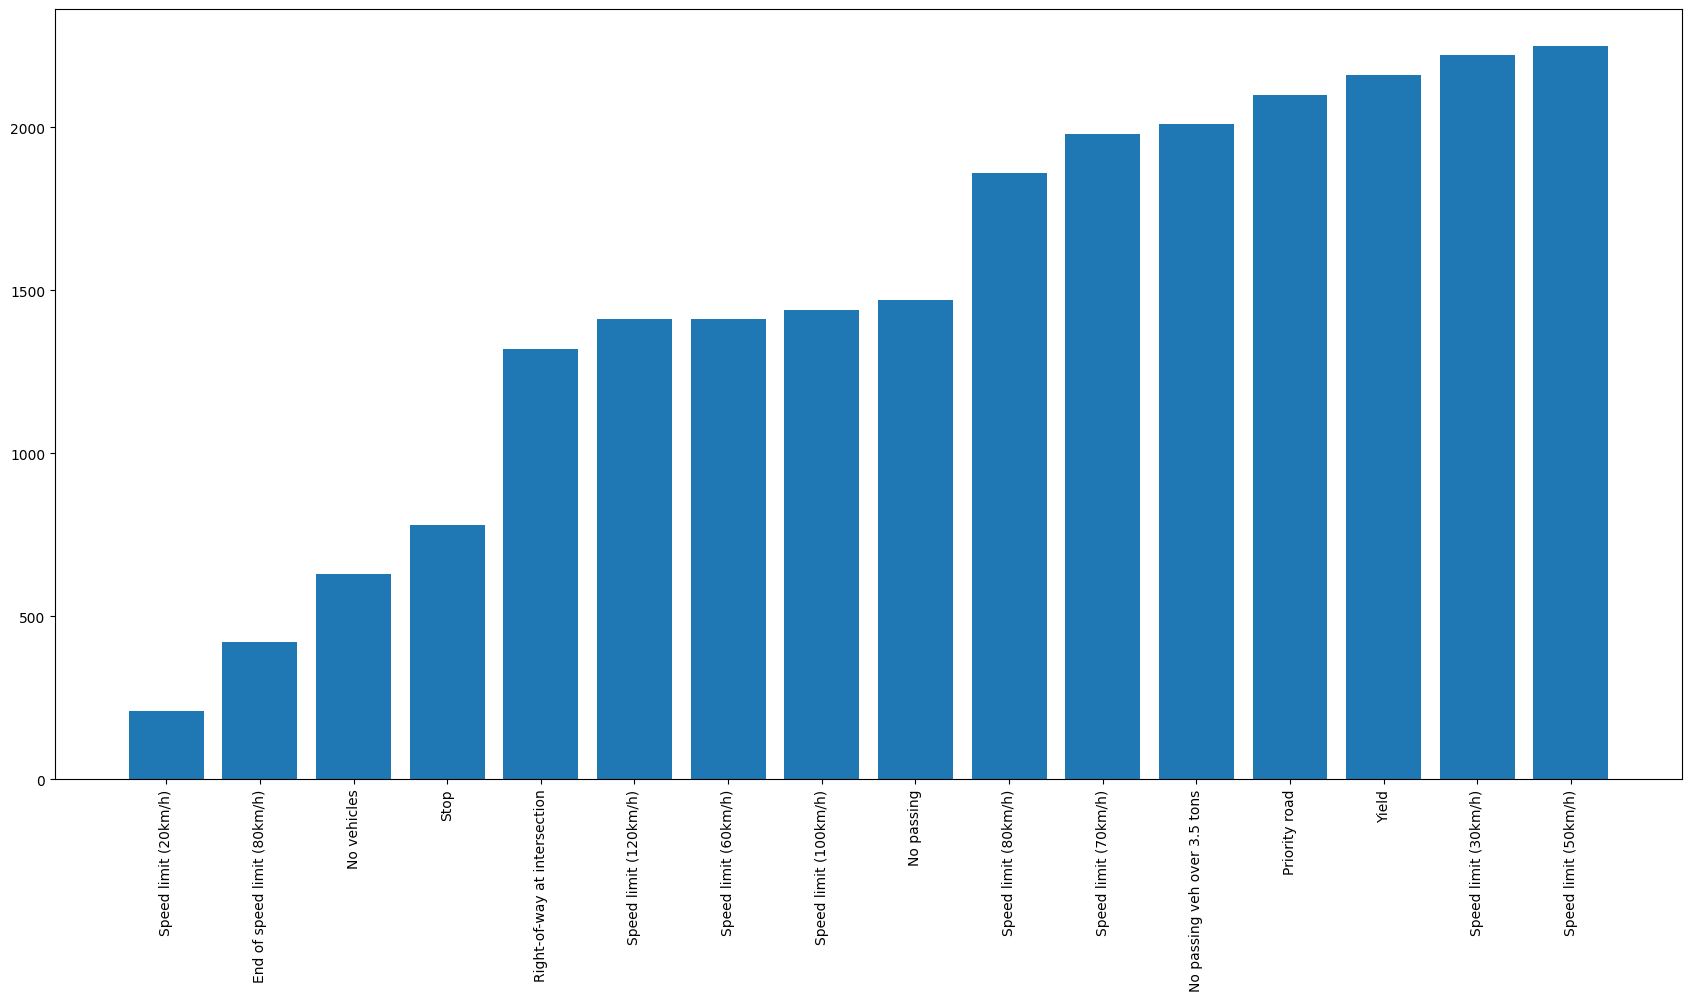

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + "/" + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

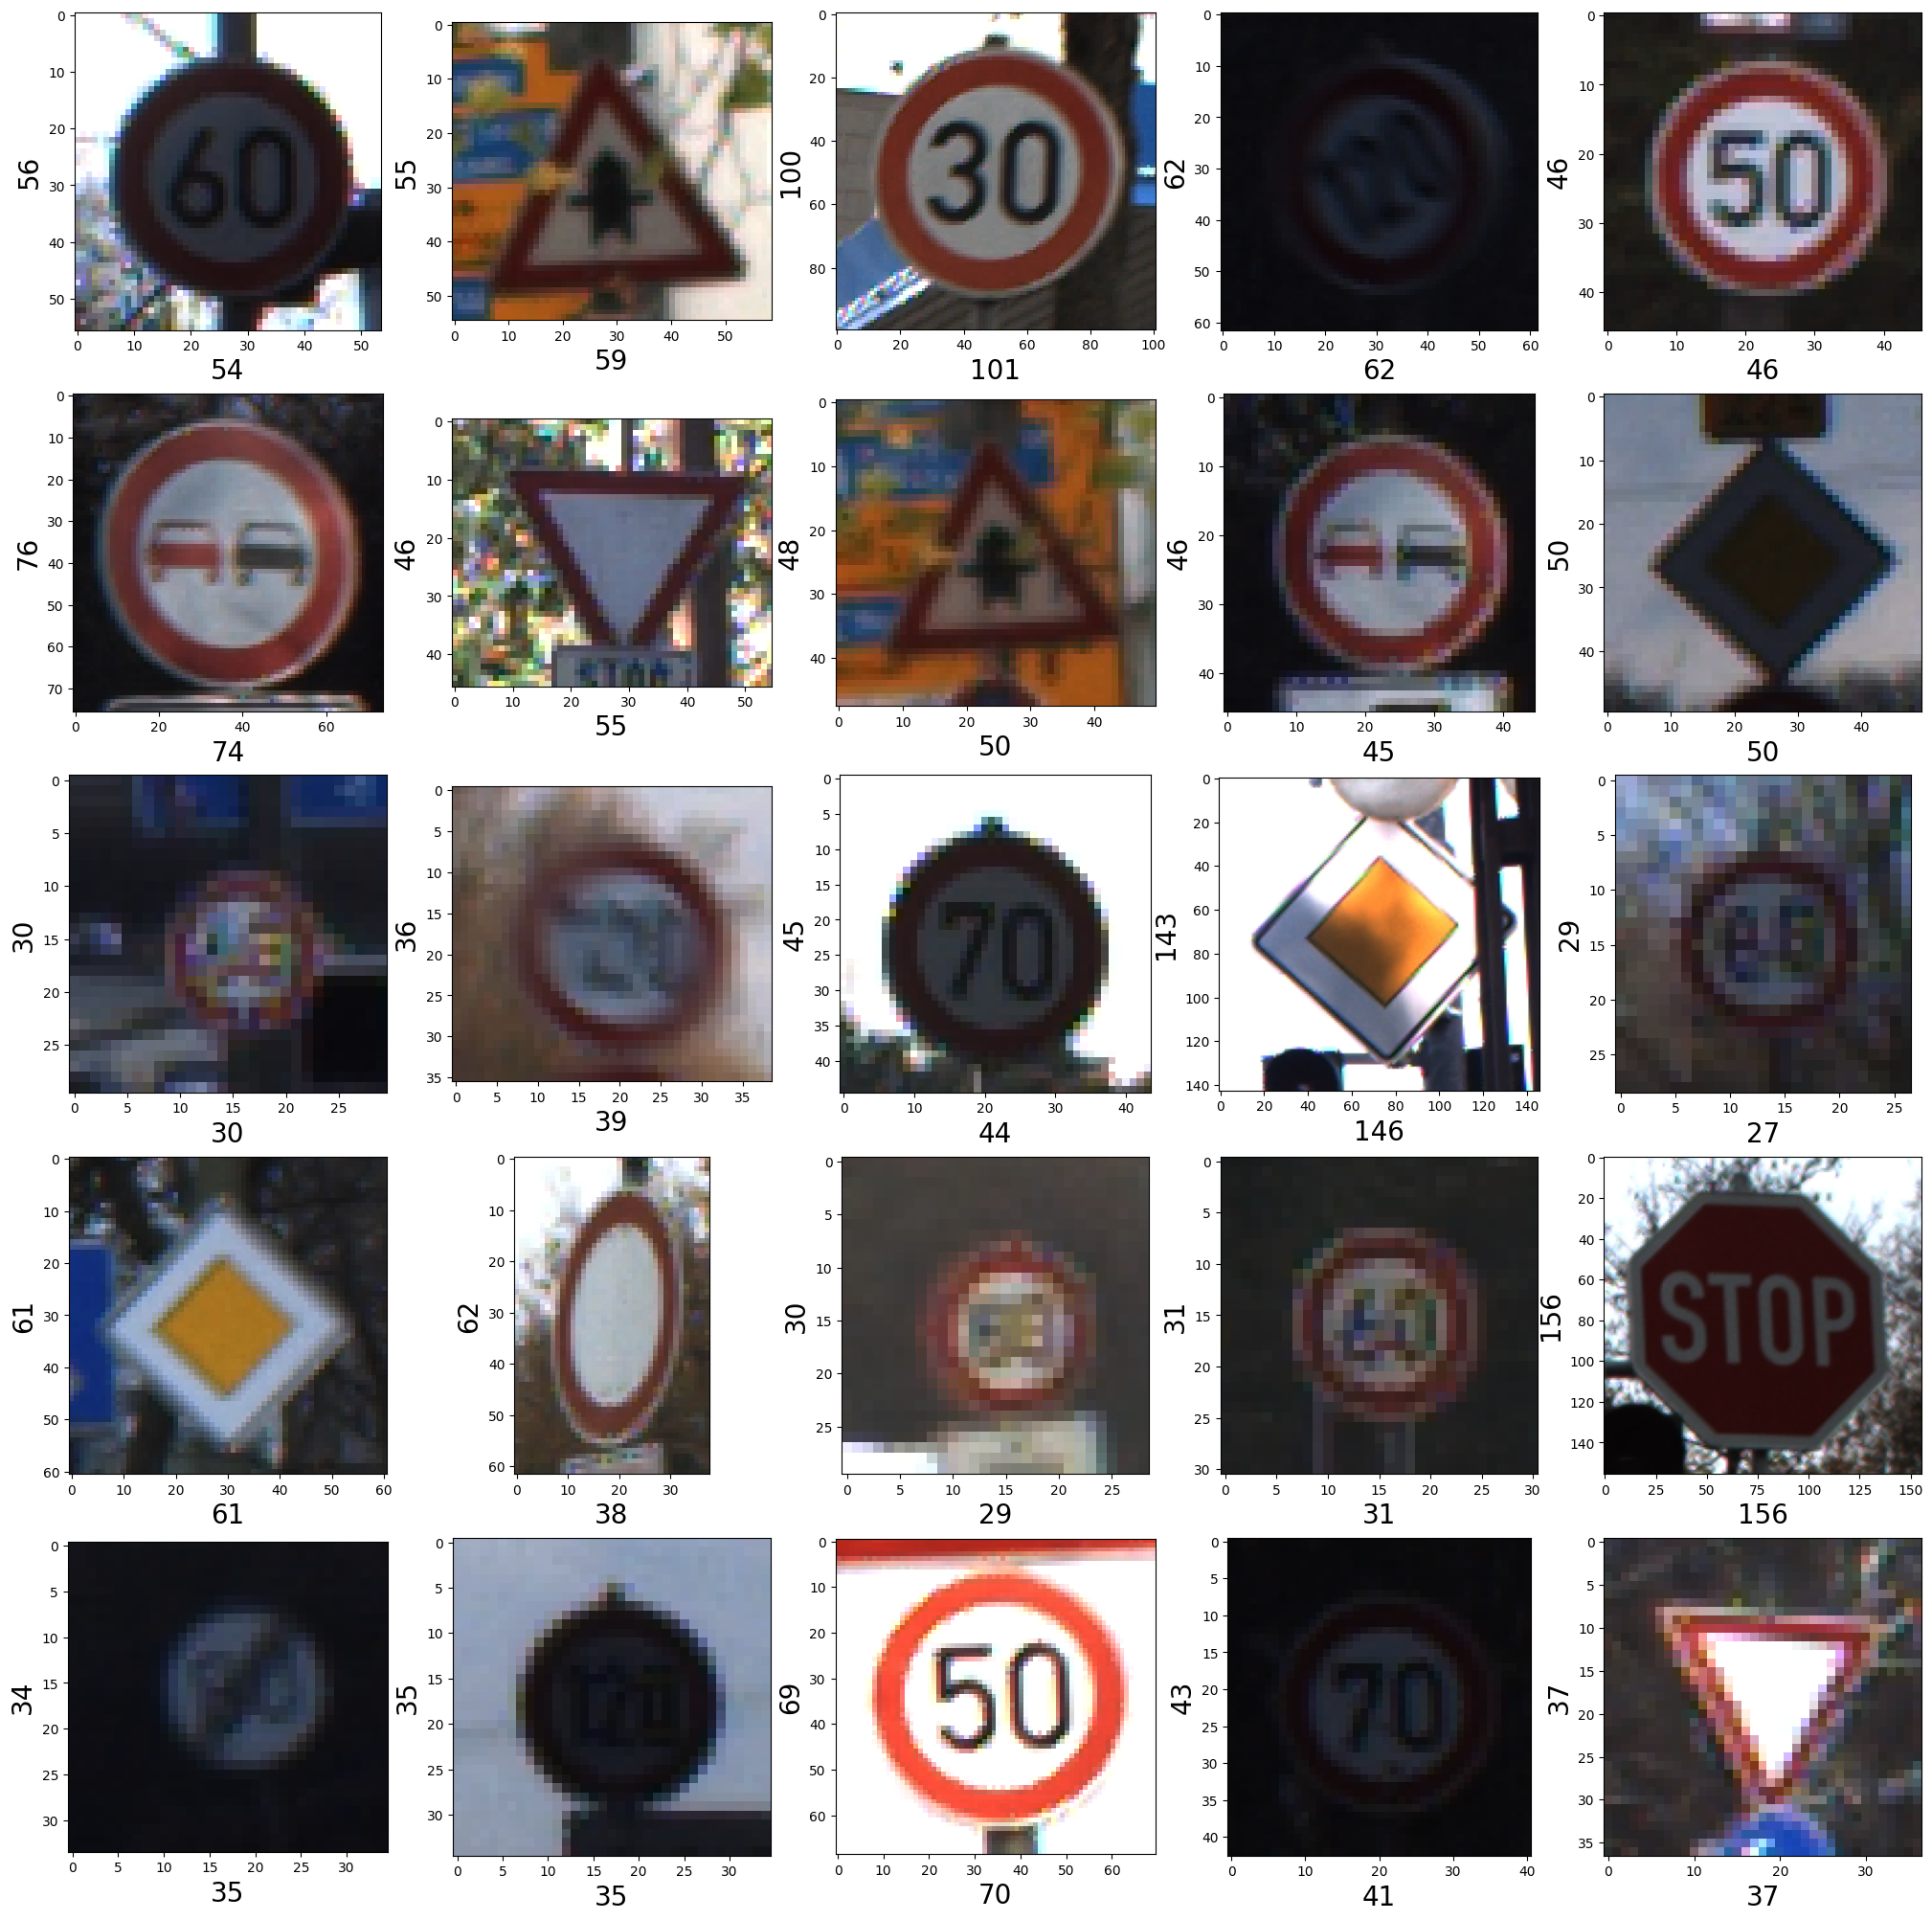

In [56]:
test = pd.read_csv(data_dir + "/Test.csv")
imgs = test["Path"].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + "/" + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize=20)
    plt.ylabel(rand_img.shape[0], fontsize=20)

## Collecting the training data

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + "/Train/" + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(23670, 30, 30, 3) (23670,)


## Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42,
                                                  shuffle=True)

X_train = X_train / 255
X_val = X_val / 255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (16569, 30, 30, 3)
X_valid.shape (7101, 30, 30, 3)
y_train.shape (16569,)
y_valid.shape (7101,)


## One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(16569, 16)
(7101, 16)


## Making the model

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='softmax')
])

In [17]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
518/518 [==============================] - 31s 55ms/step - loss: 0.8224 - accuracy: 0.7623 - val_loss: 0.4706 - val_accuracy: 0.8628
Epoch 2/30
518/518 [==============================] - 28s 54ms/step - loss: 0.1437 - accuracy: 0.9556 - val_loss: 0.0357 - val_accuracy: 0.9890
Epoch 3/30
518/518 [==============================] - 26s 51ms/step - loss: 0.0955 - accuracy: 0.9699 - val_loss: 0.0450 - val_accuracy: 0.9858
Epoch 4/30
518/518 [==============================] - 27s 52ms/step - loss: 0.0636 - accuracy: 0.9806 - val_loss: 0.0324 - val_accuracy: 0.9917
Epoch 5/30
518/518 [==============================] - 27s 53ms/step - loss: 0.0555 - accuracy: 0.9820 - val_loss: 0.0219 - val_accuracy: 0.9927
Epoch 6/30
518/518 [==============================] - 26s 51ms/step - loss: 0.0538 - accuracy: 0.9837 - val_loss: 0.0168 - val_accuracy: 0.9952
Epoch 7/30
518/518 [==============================] - 27s 52ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.0225 - val_accuracy:

## Save model to disk

In [39]:
model.save("model.h5")

In [30]:
model.save_weights("/output/")

In [40]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',


## Evaluating the model

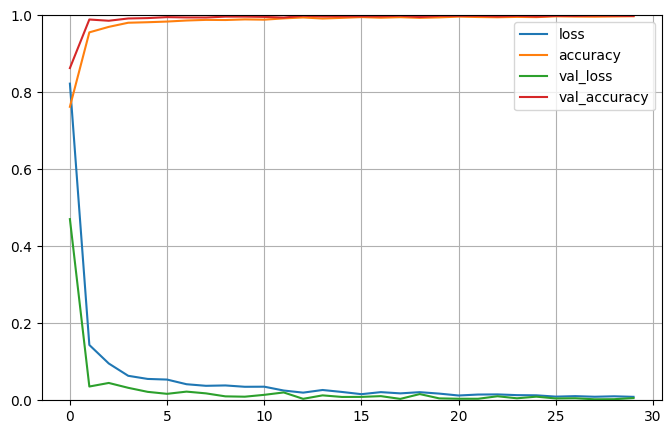

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [61]:
test = pd.read_csv(data_dir + "/Test.csv")

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test / 255

pred = np.argmax(model.predict(X_test), axis=-1)

print("Test data accuracy: ", accuracy_score(labels, pred) * 100)

243/243 [==============================] - 4s 17ms/step
Test data accuracy:  99.09909909909909


## Visualizing the confusion matrix

In [62]:
cf = confusion_matrix(labels, pred)

<Axes: >

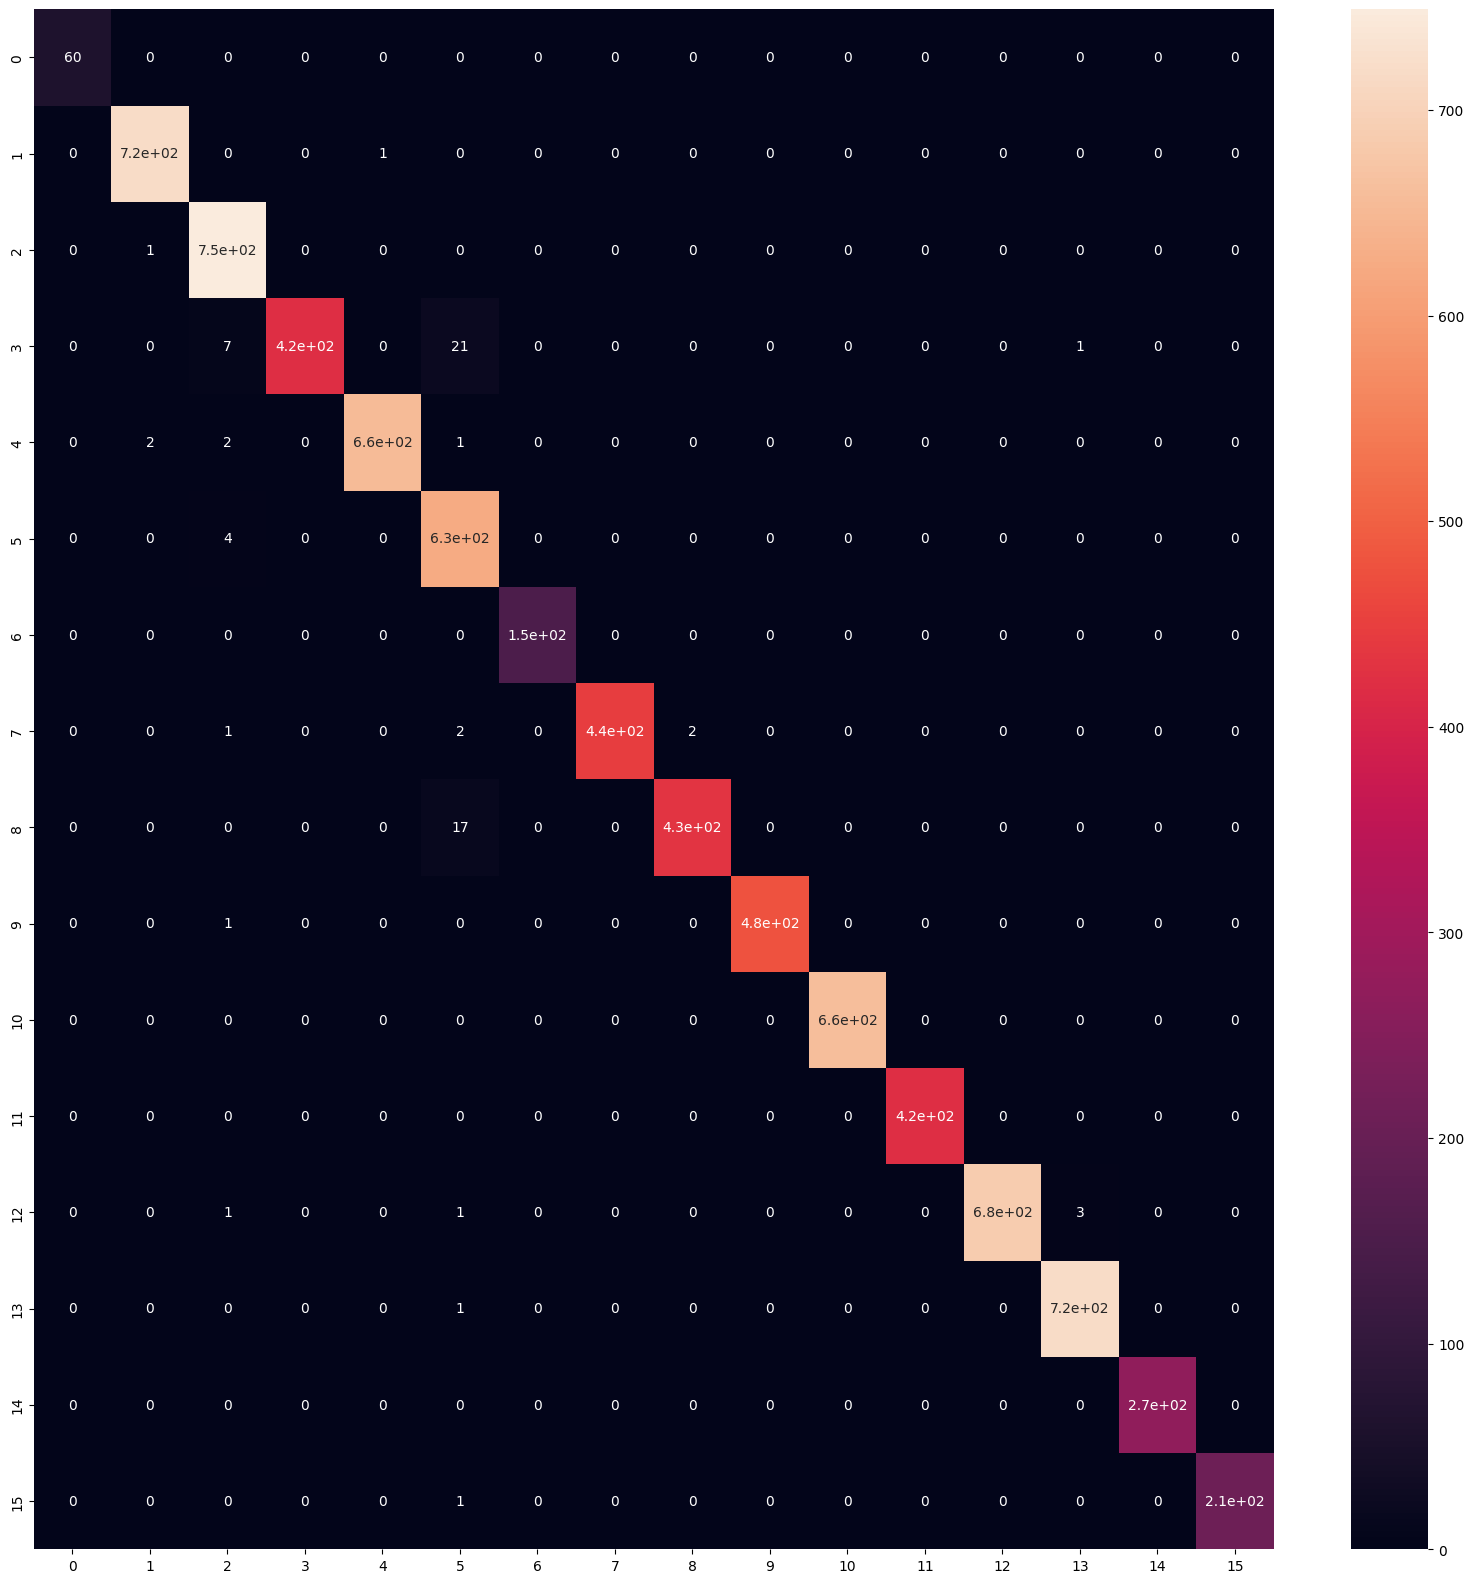

In [63]:
df_cm = pd.DataFrame(cf, index=classes, columns=classes)
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [64]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       1.00      0.94      0.97       450
           4       1.00      0.99      1.00       660
           5       0.93      0.99      0.96       630
           6       1.00      1.00      1.00       150
           7       1.00      0.99      0.99       450
           8       1.00      0.96      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.99      1.00       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210

    accuracy                           0.99      7770
   macro avg       0.99   

## Prediction on test data

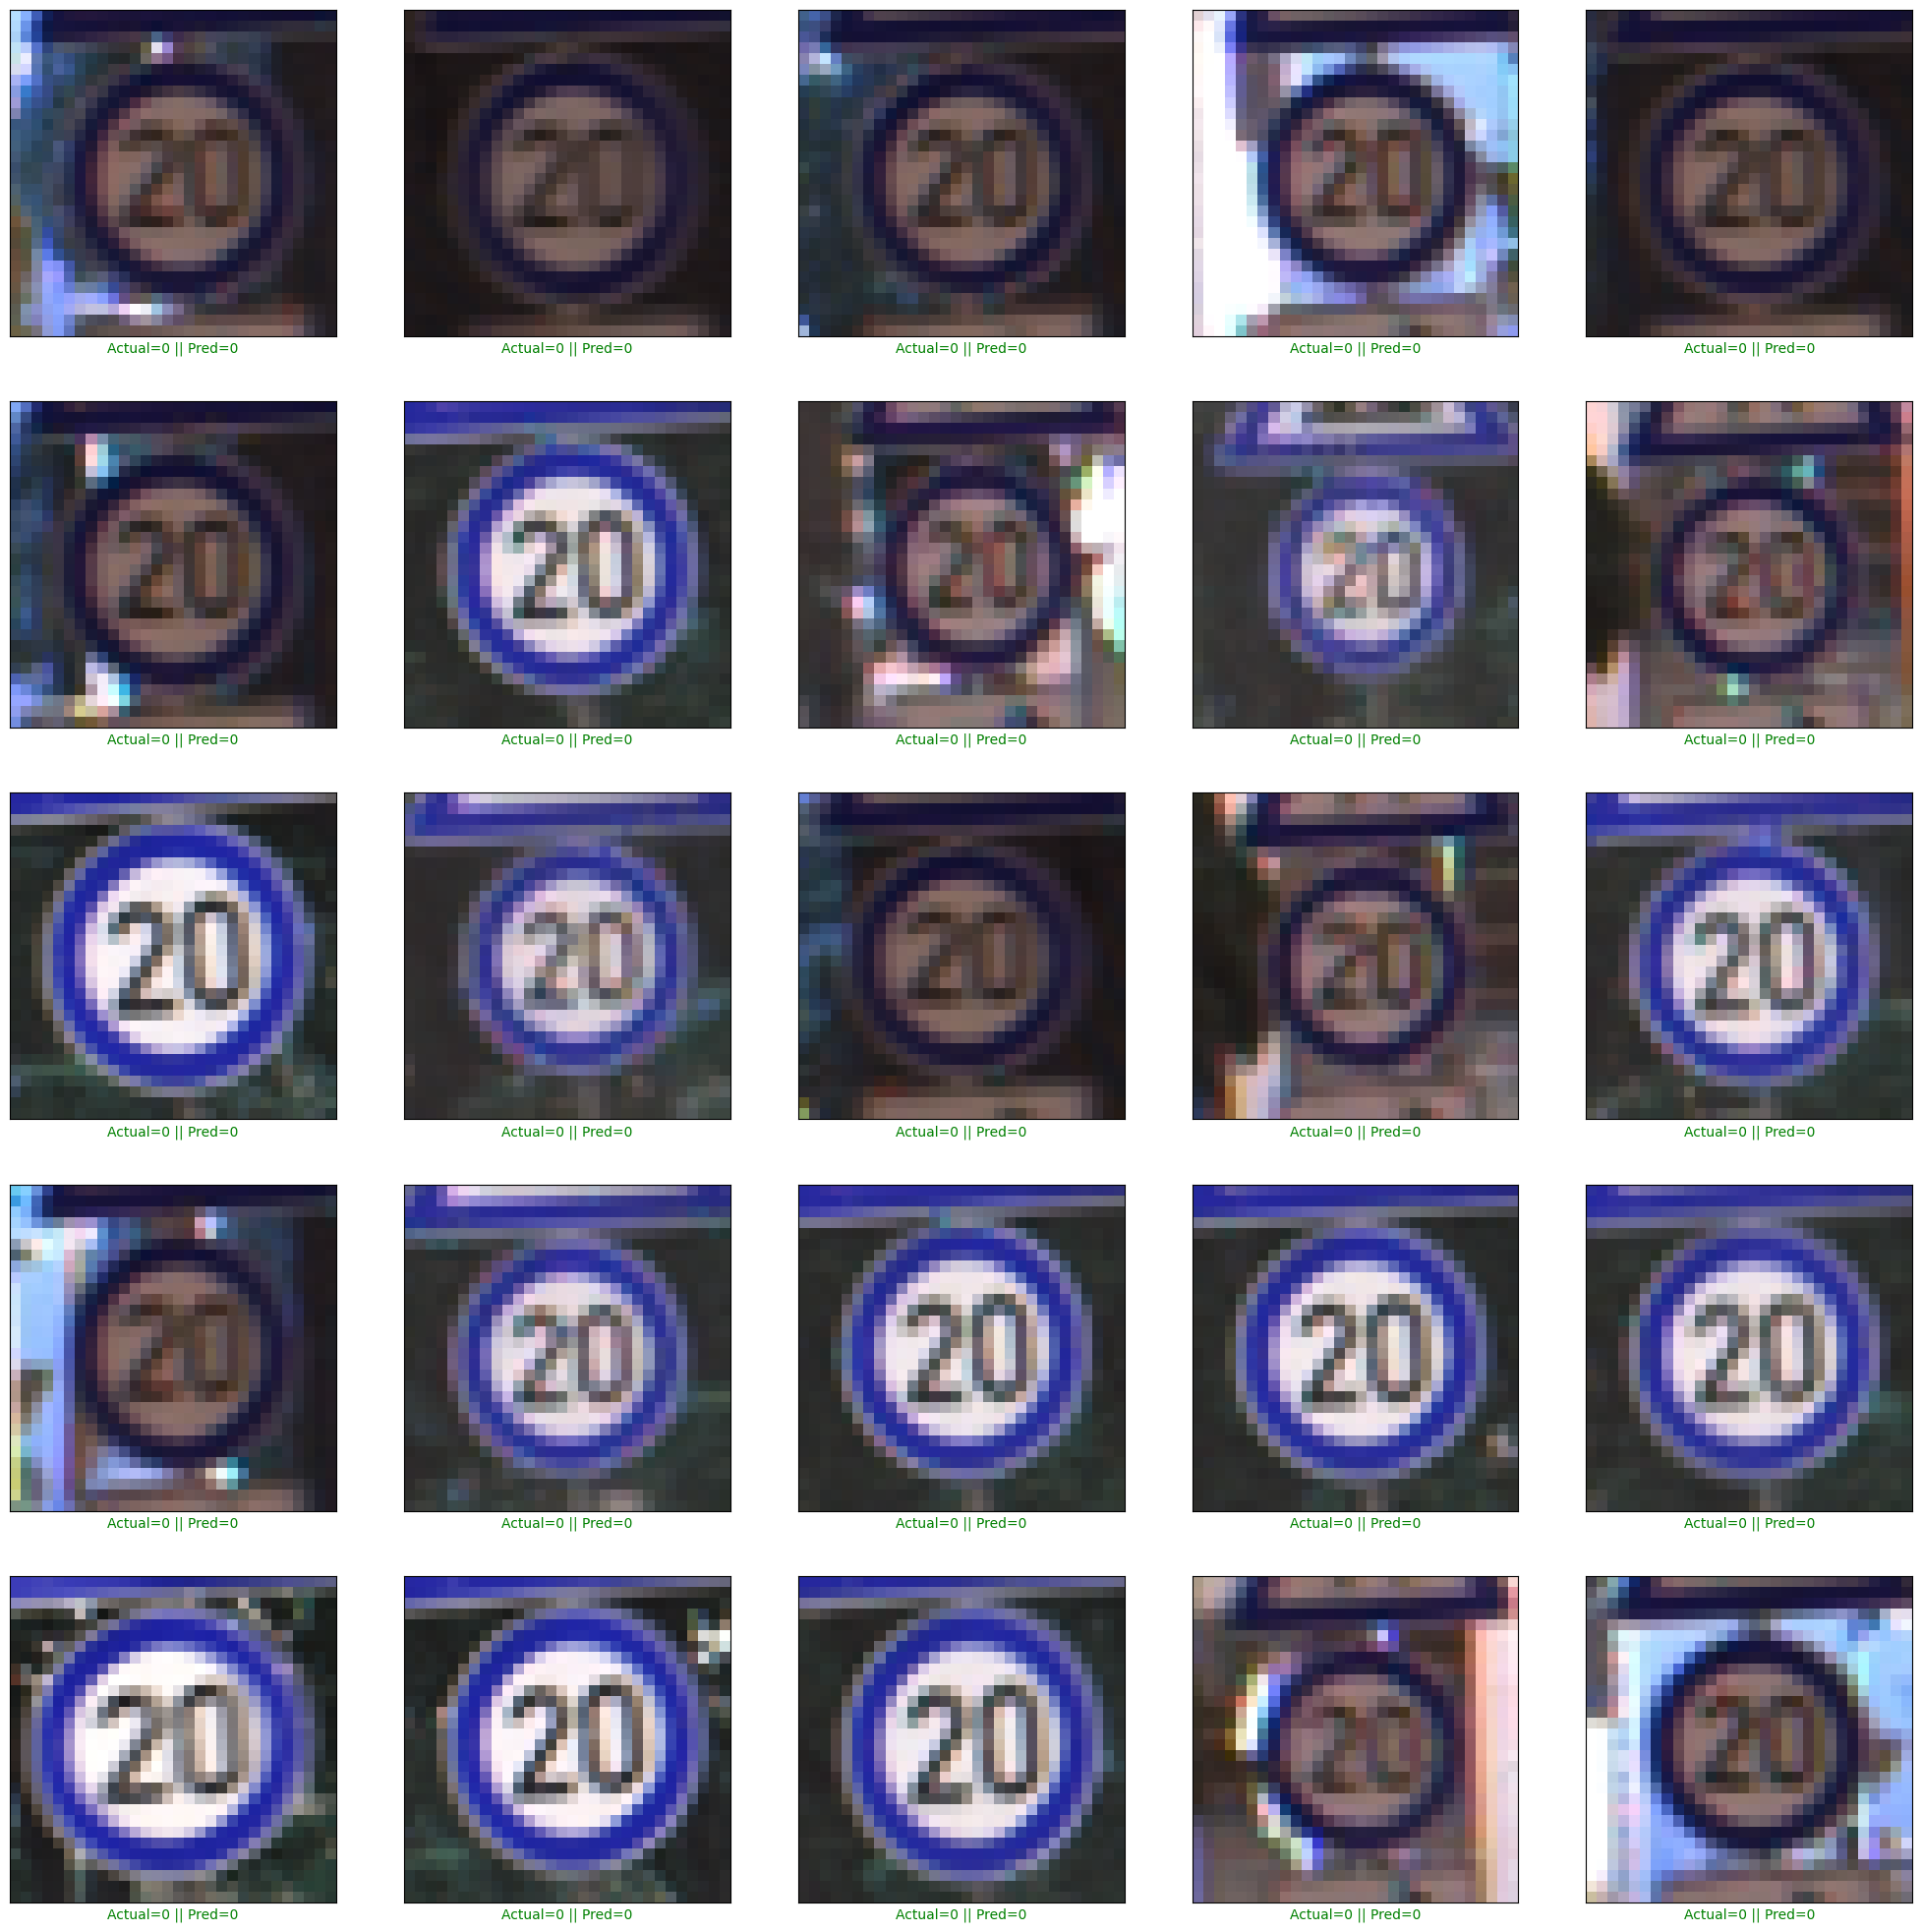

In [65]:
plt.figure(figsize=(25,25))

start_index = 0
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual,prediction), color=col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [69]:
model_path = "model.h5"
loaded_model = keras.models.load_model(model_path)

image = cv2.imread("Test/00026.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

1/1 [==============================] - 0s 233ms/step


13